In [1]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
print("Done!")
import sys
sys.path.append("..")

print("Done!")

Done!
Done!


(60000, 28, 28)
(60000, 784)
(784,)


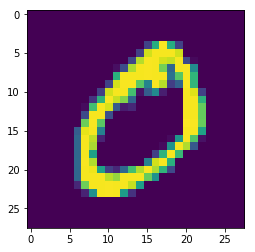

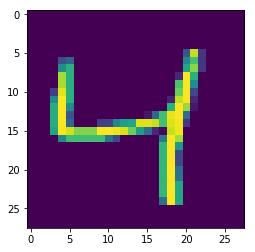

In [2]:
xtrain = np.load("../mnist_xtrain.npy")
print(xtrain.shape)
d = []
for el in xtrain:
    el = el / 255.
    el = utils.flatten(el)
    d.append(el)

d = np.array(d)
print(d.shape)
dat = d[1]
print(dat.shape)
dat = np.reshape(dat, (28,28))
plt.imshow(dat)
plt.show()
plt.imshow(np.reshape(d[2], (28,28)))
plt.show()


In [3]:
class Model():
    
    def __init__(self, data, epochs, convergence_runs=200):
        self.convergence_runs = 200
        self.data = data
        self.epochs = epochs
        self.layers = []
        self.upwards = []
        self.downwards = []
        self.wlist = []
        self.predlist = []
        self.pelist = []
        self.full_predlist = []
        
    def add(self, layer):
        self.layers.append(layer)
        
    def initialize(self):
        for i, layer in enumerate(self.layers):
            self.upwards.append(np.random.normal(0,0.1, [layer.top_down_size,1]))
            self.downwards.append(np.random.normal(0,0.1, [layer.bottom_up_size,1]))
            self.wlist.append([])
            self.predlist.append([])
            self.pelist.append([])
        self.upwards.append(0)
        self.downwards.append(None)
     
    def train(self):

        for epoch in range(self.epochs):
            print("Starting epoch: " + str(epoch))
            self.downwards[-1] = None 
            for dat in self.data:
                self.upwards[0] = np.reshape(dat,(784,1)) 
                for i in range(self.convergence_runs):
                    for j,layer in enumerate(self.layers):
                        #print("Layer " + str(j))
                        up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1])
                        #print(up)
                        #print(down)
                        self.upwards[j+1] = up
                        self.downwards[j] = down 
                        self.wlist[j].append(np.sum(weights))
                        self.predlist[j].append(np.sum(preds))
                        self.pelist[j].append(np.sum(pes))
                        
            self.full_predlist.append(np.copy(self.layers[0].preds))
            
            
    def get_latents(self, inputs):
        latents = []
        for inp in inputs:
            for i in range(self.convergence_runs):
                self.upwards[0] = np.reshape(inp, (784,1))
                for j,layer in enumerate(self.layers):
                    #print("Layer : " + str(j))
                    up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1], training=False) # as only inference!
                    self.upwards[j+1] = up
                    self.downwards[j] = down 
            latents.append(np.copy(self.layers[-1].latents)) # this should hopefully function!
        return latents
    
    def get_predictions_from_latents(self, latents):
        predictions = []
        """
        for l in latents:
            print(np.mean(l))
            for i in range(self.convergence_runs):
                self.layers[-1].latents = l
                for j, layer in enumerate(self.layers):
                    up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1], training=False) # as only inference!
                    self.upwards[j+1] = up
                    self.downwards[j] = down 
                print(np.mean(self.layers[0].preds))
            plt.imshow(np.reshape(self.layers[0].preds, (28,28)))
            plt.show()
            predictions.append(np.copy(self.layers[0].preds))
        """
        for l in latents:
            l1 = self.layers[0]
            pred = l1.top_down_prediction(l1.weights, l)
            predictions.append(pred)
            
        return predictions
    
    def interpolation_latents(self,l1, l2, num_steps):
        interps = []
        diff = (l2 - l1) / num_steps
        for i in range(num_steps):
            latent = l1 + (i * diff)
            for i in range(self.convergence_runs):
                self.upwards[0] = np.reshape(latent, (784,1))
                for j,layer in enumerate(self.layers):
                    #print("Layer : " + str(j))
                    up, down, weights, preds, pes = layer.run(self.upwards[j], self.downwards[j+1], training=False) # as only inference!
                    self.upwards[j+1] = up
                    self.downwards[j] = down 
            interps.append(np.copy(self.layers[-1].latents)) 
        return interps

    def interpolate(self, l1, l2,num_steps):
        interps = self.interpolation_latents(l1, l2, num_steps)
        preds = self.get_predictions_from_latents(interps)
        return preds
            
                        
    def plot(self):
        self.wlist = np.array(self.wlist[0])
        self.predlist = np.array(self.predlist[0])
        self.pelist = np.array(self.pelist[0])
        plt.plot(self.wlist)
        plt.show()
        plt.plot(self.predlist)
        plt.show()
        plt.plot(self.pelist)
        plt.show()
        for pred in self.full_predlist:
            plt.imshow(np.reshape(pred, (28,28)))
            plt.show()
        
                           
class SigmoidLayer():
    
    def __init__(self,learning_rate, bottom_up_size, top_down_size, input_layer=False, weight_update_ratio = 1):
        self.learning_rate = learning_rate
        self.bottom_up_size = bottom_up_size
        self.top_down_size = top_down_size
        self.weights = np.random.normal(0, 0.1, [bottom_up_size, top_down_size])
        self.latents = np.random.normal(0, 0.1, [bottom_up_size,1])
        self.input_layer = input_layer
        self.weight_update_ratio = weight_update_ratio
               
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-1*x))    
    
    def sigmoidderiv(self,x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def upward_projection(self,pe, w):
        return sigmoidderiv(np.dot(w.T, pe)) 

    def update_weight(self,predderiv, pe, u):
        return learning_rate * np.dot(pe * predderiv,  u.T)

    def update_cause_unit(self,bu , pe):
        return learning_rate * np.subtract(bu, pe)

    def top_down_prediction(self,w, td):
        return self.sigmoid(np.dot(w, td))

    def prediction_error(self,u, pred):
        return np.subtract(u, pred)

    def prediction_derivative(self,w,u):
        return self.sigmoidderiv(np.dot(w, u))
   
    def run(self, bottom_up, top_down, training=True):
        self.bottom_up = bottom_up
        self.top_down = top_down
        if self.input_layer:
            self.latents = self.bottom_up
        if self.top_down is None:
            self.prediction_errors = self.prediction_error(self.latents, 0)
            self.latents += self.update_cause_unit(self.bottom_up, self.prediction_errors)
            self.preds = self.prediction_errors
            return None, self.latents, self.weights, self.prediction_errors, self.prediction_errors
        else:
            self.preds = self.top_down_prediction(self.weights, self.top_down)
            self.prediction_errors = self.prediction_error(self.latents, self.preds)  
            self.predderiv = self.prediction_derivative(self.weights, top_down)
            self.up = self.upward_projection(self.prediction_errors, self.weights)
            #print(np.sum(pred))
            #print(np.sum(pe1))
            #print(np.sum(up))
            if not self.input_layer:
                self.latents += self.update_cause_unit(self.bottom_up, self.prediction_errors)
            if i % weight_update_ratio == 0 and training is True:
                self.weights += self.update_weight(self.predderiv,self.prediction_errors, self.top_down)
            
            return self.up, self.latents, self.weights, self.preds, self.prediction_errors

print("DOne!")

DOne!


In [4]:
i = 4
weight_update_ratio = 1
learning_rate = 0.1
m = Model(d[1:500], 100, convergence_runs = 1000)
l1 = SigmoidLayer(0.01, 784, 50, input_layer=True)
l2 = SigmoidLayer(0.01, 50,1)
m.add(l1)
m.add(l2)
m.initialize()
m.train()
m.plot()

Starting epoch: 0


KeyboardInterrupt: 

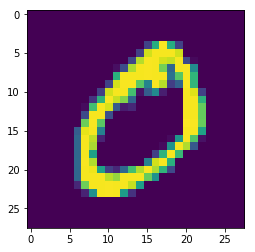

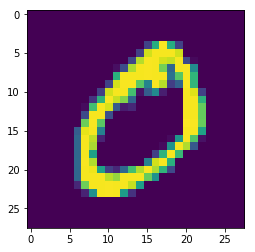

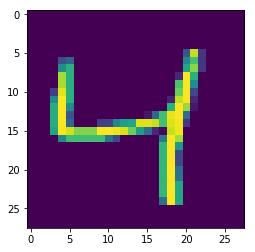

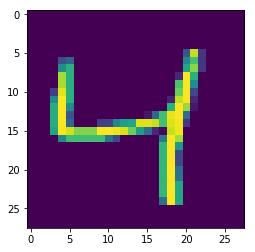

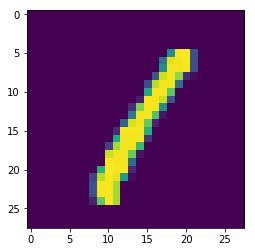

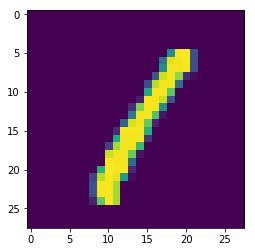

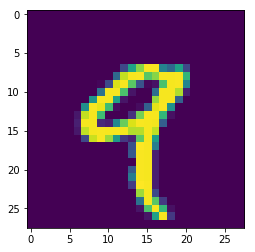

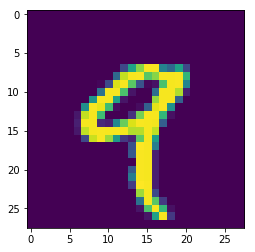

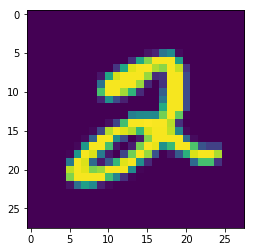

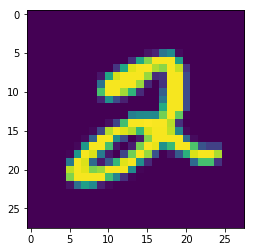

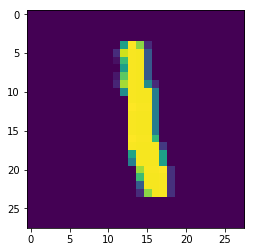

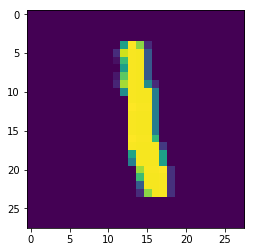

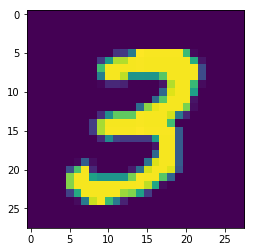

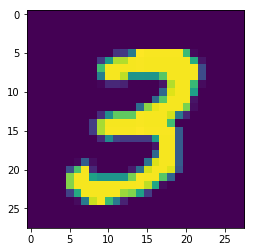

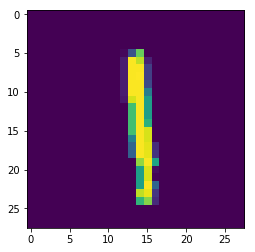

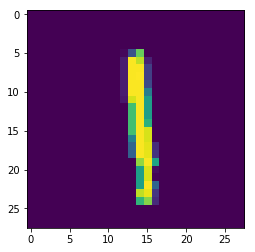

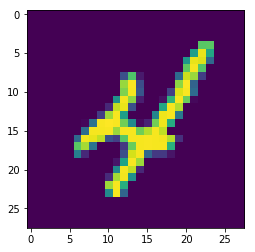

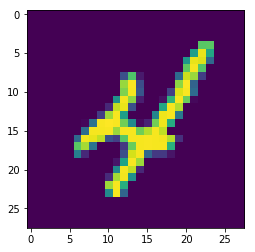

In [25]:
latents = m.get_latents(d[1:10])
preds = m.get_predictions_from_latents(latents)
for dat, pred in zip(d[1:10], preds):
    plt.imshow(np.reshape(dat, (28,28)))
    plt.show()
    plt.imshow(np.reshape(dat, (28,28)))
    plt.show()
    

Starting epoch: 0
Starting epoch: 1
Starting epoch: 2
Starting epoch: 3
Starting epoch: 4
Starting epoch: 5
Starting epoch: 6
Starting epoch: 7
Starting epoch: 8
Starting epoch: 9
Starting epoch: 10
Starting epoch: 11
Starting epoch: 12
Starting epoch: 13
Starting epoch: 14
Starting epoch: 15
Starting epoch: 16
Starting epoch: 17
Starting epoch: 18
Starting epoch: 19
Starting epoch: 20
Starting epoch: 21
Starting epoch: 22
Starting epoch: 23
Starting epoch: 24
Starting epoch: 25
Starting epoch: 26
Starting epoch: 27
Starting epoch: 28
Starting epoch: 29
Starting epoch: 30
Starting epoch: 31
Starting epoch: 32
Starting epoch: 33
Starting epoch: 34
Starting epoch: 35
Starting epoch: 36
Starting epoch: 37
Starting epoch: 38
Starting epoch: 39
Starting epoch: 40
Starting epoch: 41
Starting epoch: 42
Starting epoch: 43
Starting epoch: 44
Starting epoch: 45
Starting epoch: 46
Starting epoch: 47
Starting epoch: 48
Starting epoch: 49
Starting epoch: 50
Starting epoch: 51
Starting epoch: 52
Sta

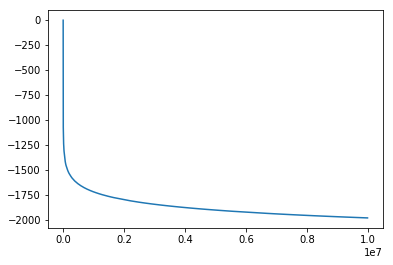

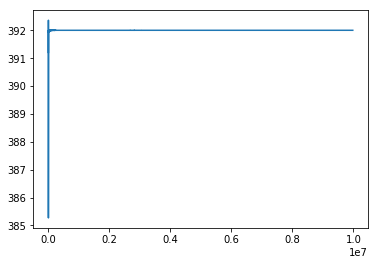

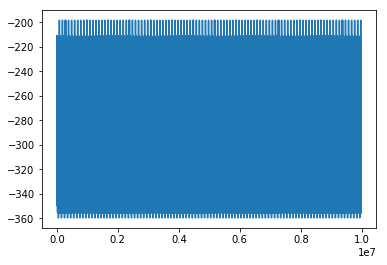

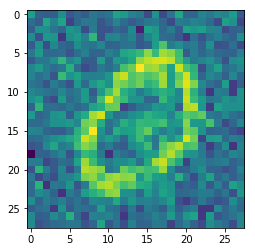

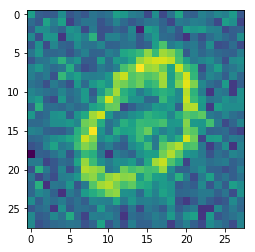

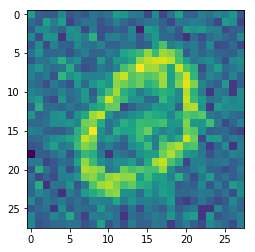

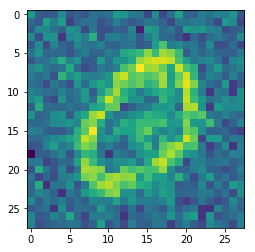

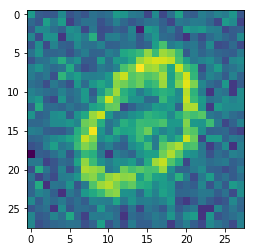

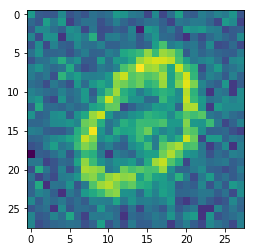

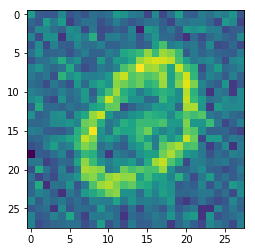

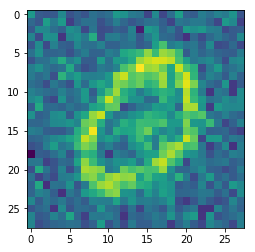

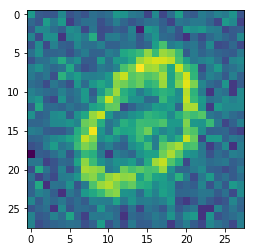

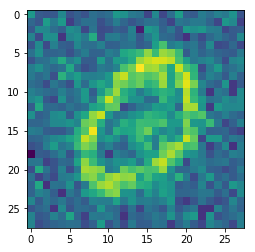

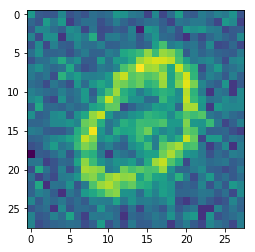

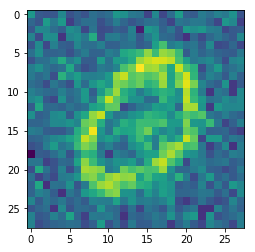

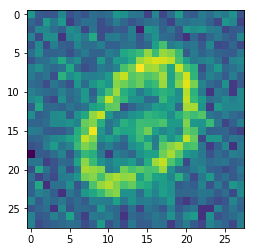

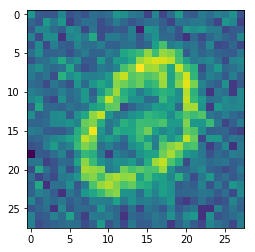

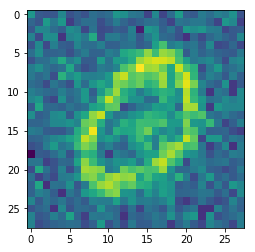

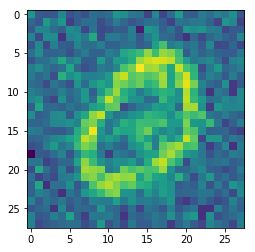

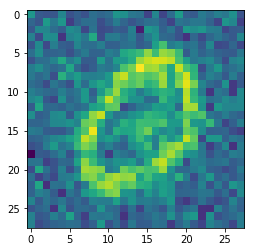

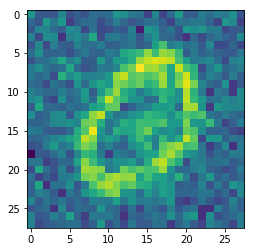

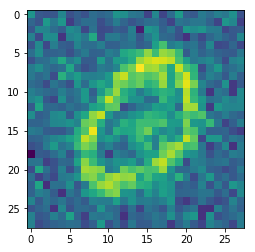

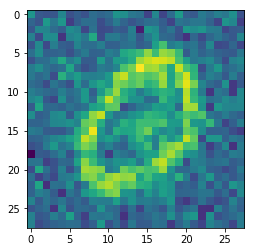

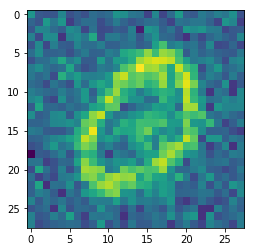

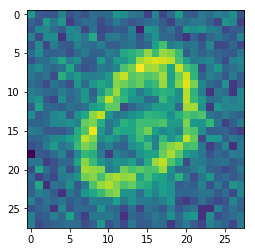

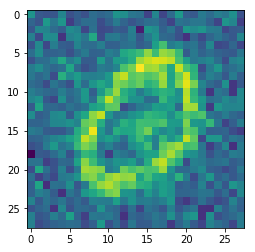

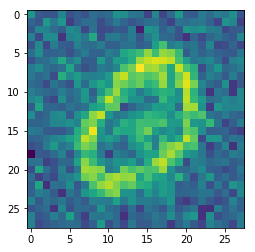

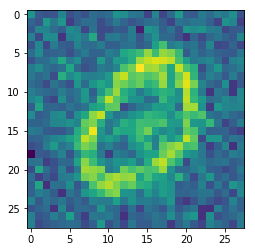

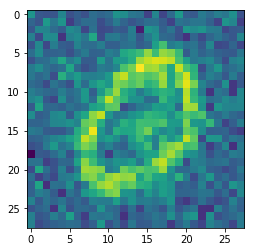

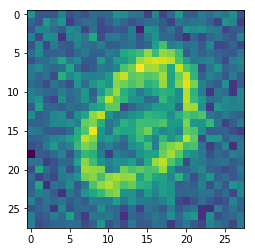

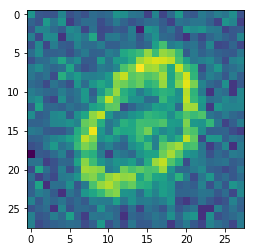

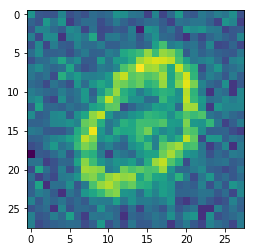

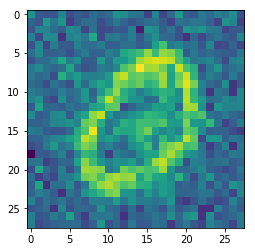

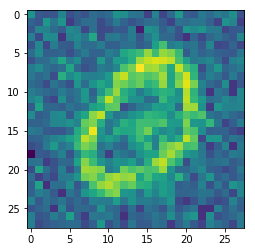

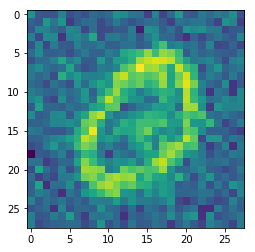

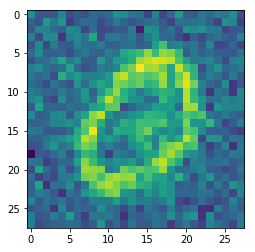

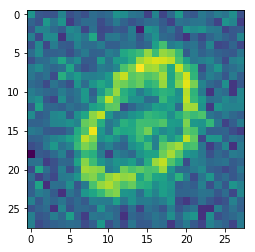

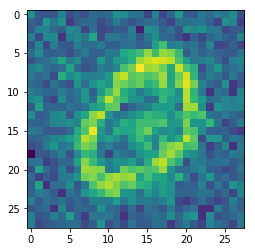

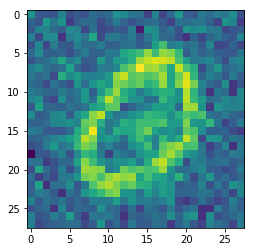

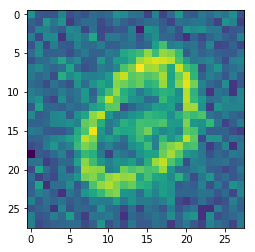

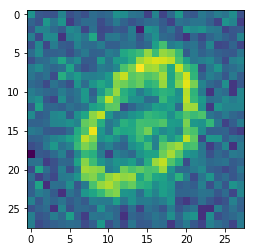

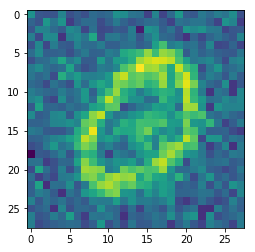

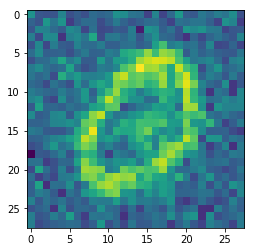

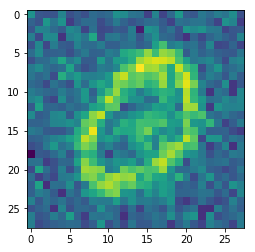

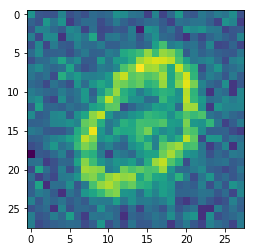

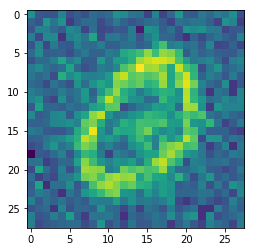

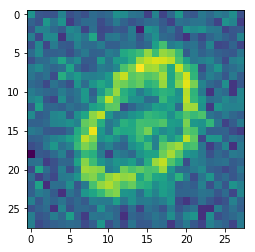

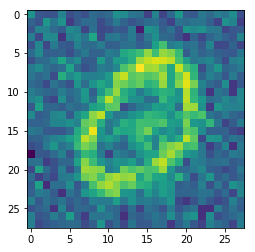

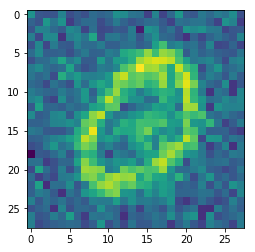

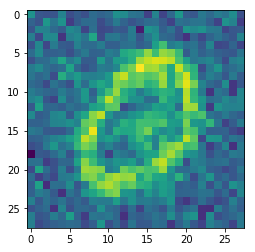

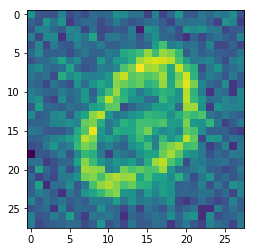

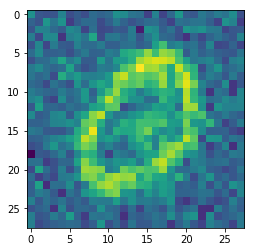

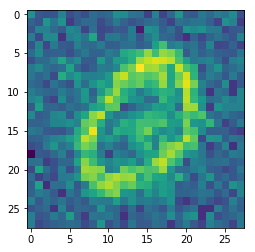

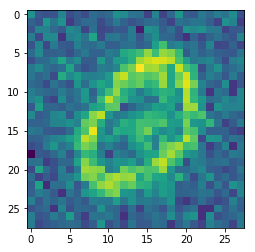

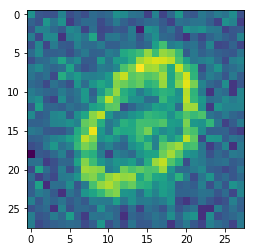

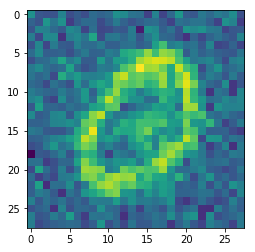

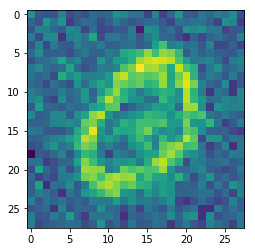

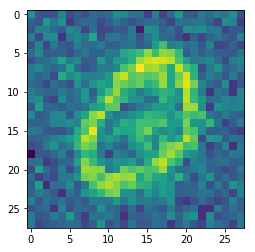

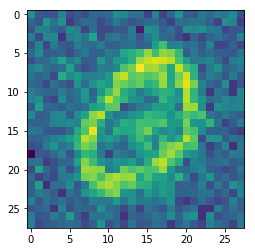

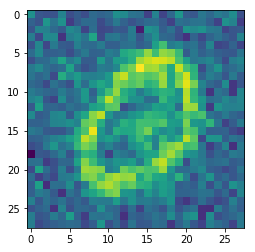

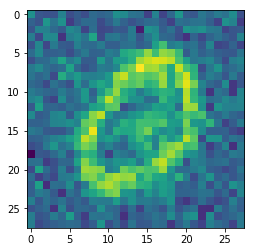

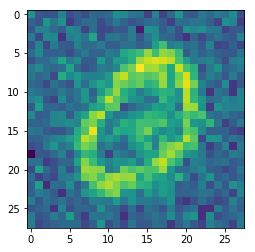

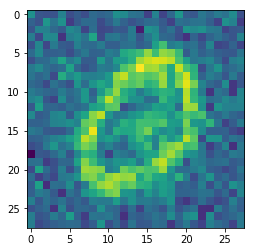

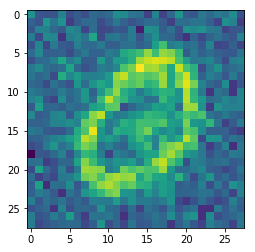

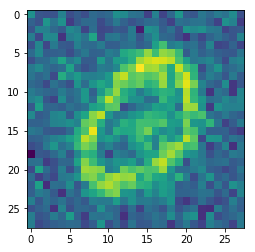

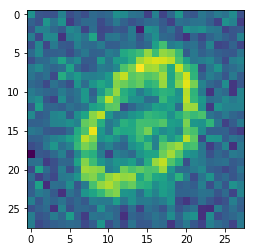

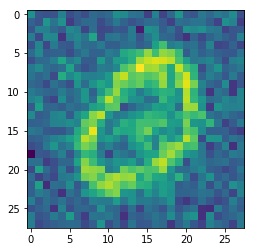

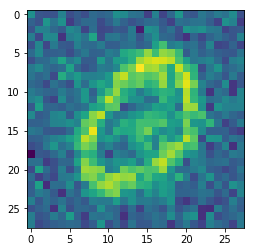

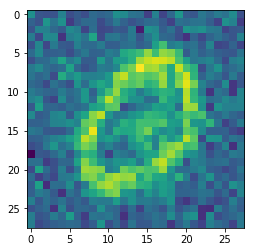

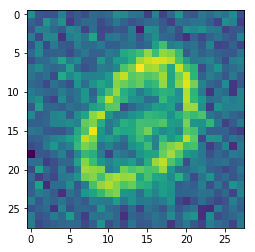

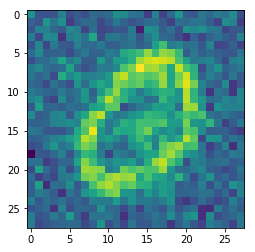

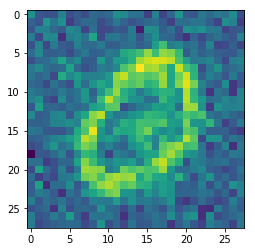

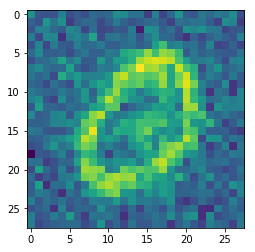

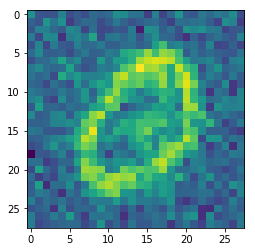

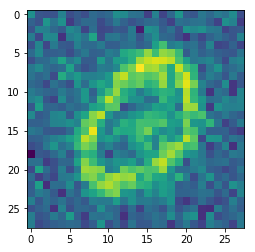

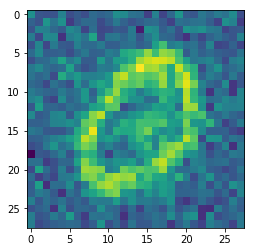

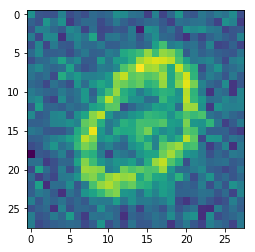

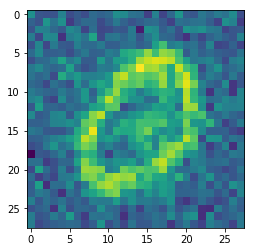

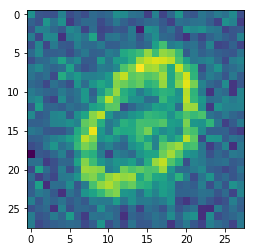

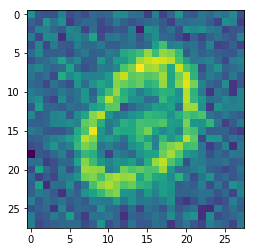

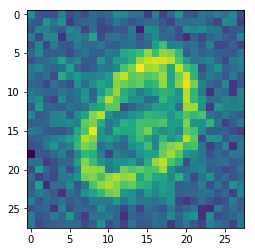

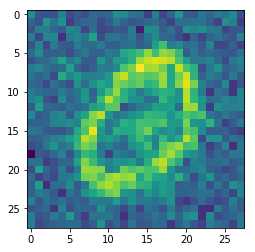

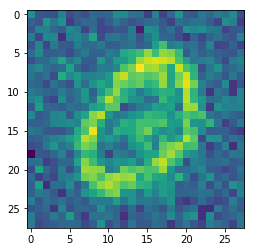

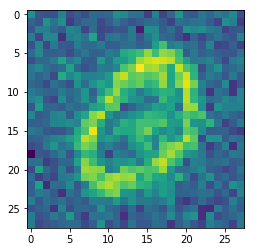

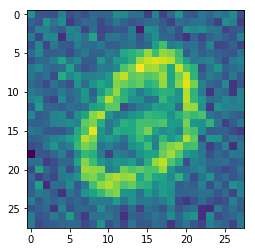

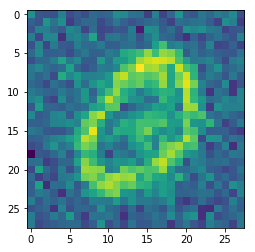

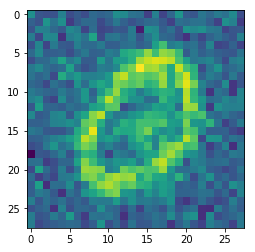

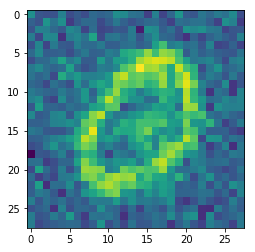

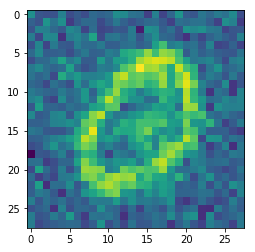

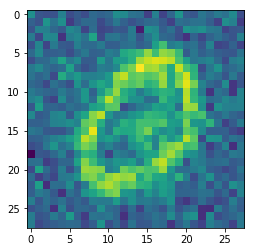

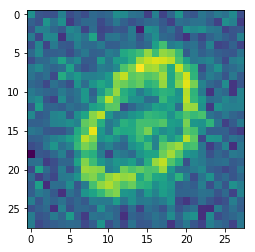

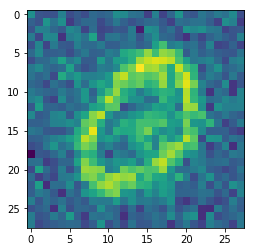

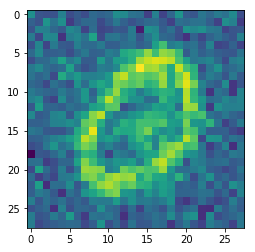

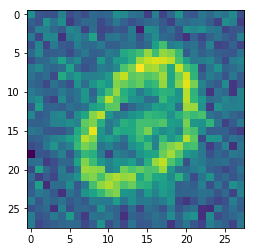

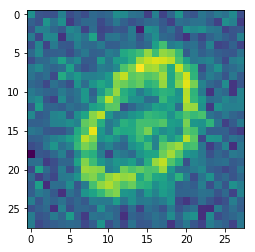

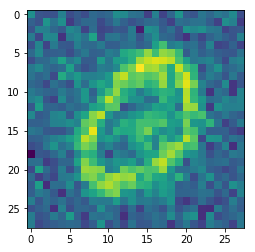

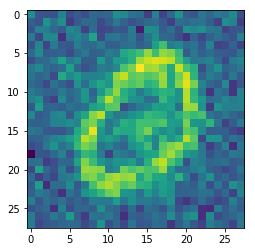

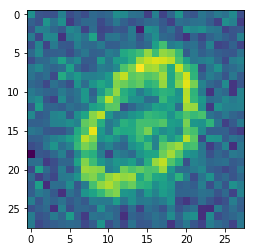

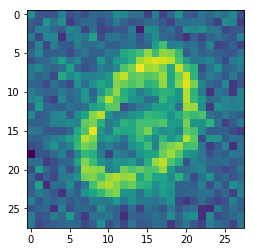

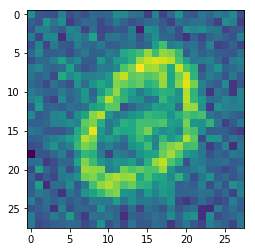

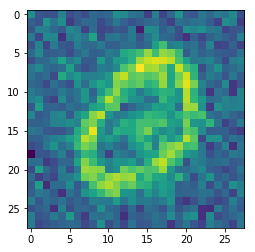

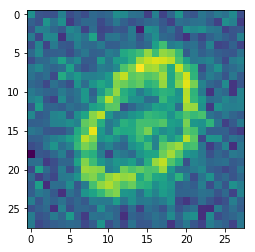

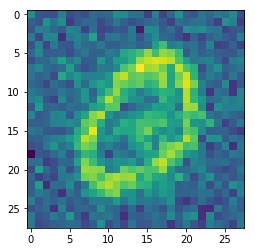

In [5]:
ring
m2 = Model(d[1:500], 100, convergence_runs = 1000)
l1 = SigmoidLayer(0.01, 784, 50, input_layer=True)
l2 = SigmoidLayer(0.01, 50,1)
m2.add(l1)
m2.add(l2)
m2.initialize()
m2.train()
m2.plot()

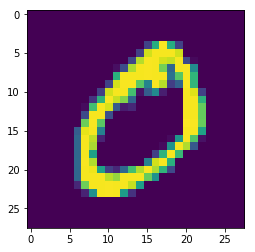

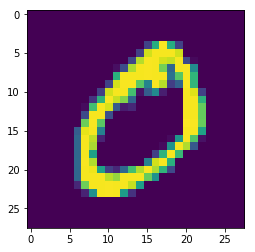

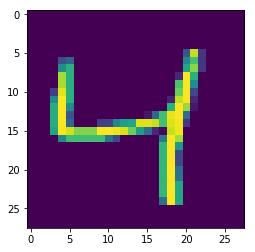

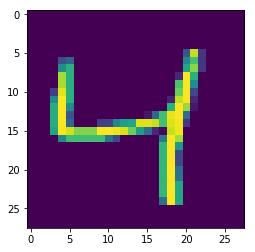

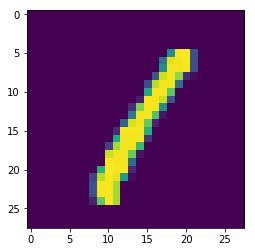

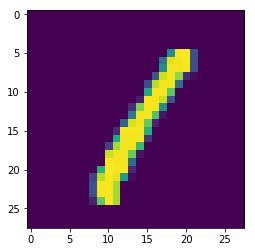

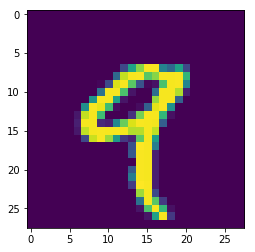

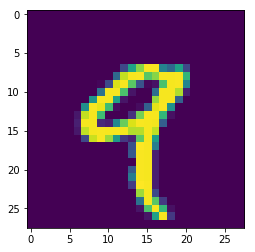

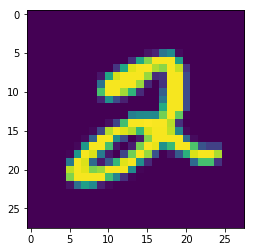

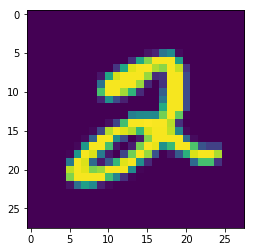

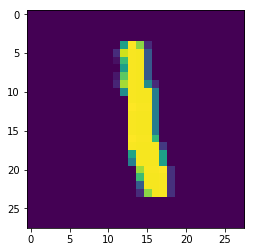

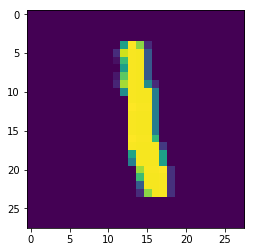

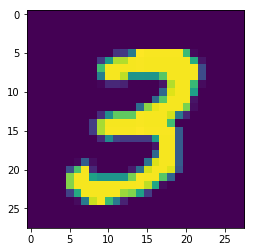

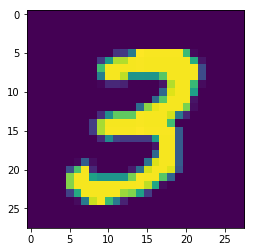

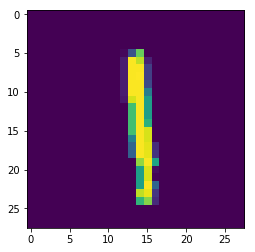

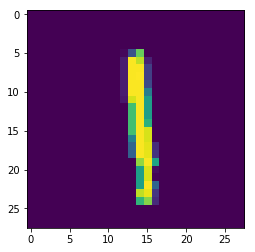

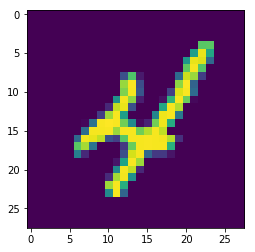

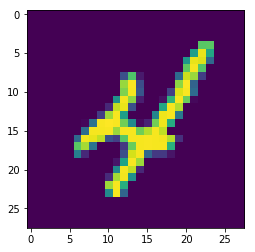

In [7]:
latents = m2.get_latents(d[1000:1010])
preds = m2.get_predictions_from_latents(latents)
for dat, pred in zip(d[1:10], preds):
    plt.imshow(np.reshape(dat, (28,28)))
    plt.show()
    plt.imshow(np.reshape(dat, (28,28)))
    plt.show()

(450, 50, 1)
[35, 50, 39, 46, 50, 42, 45, 53, 41, 49]
[0.04978782255869594, 0.01230588368681813, 0.10742164208813525, 0.059650681722115614, 0.08170955098307488, 0.0442586822117224, 0.11007934107244942, 0.032142176081121465, 0.04947516004790478, 0.025859285117877422]
[0.008962083462283334, 0.00010624549938835872, 0.058694980008805527, 0.02603533801961921, 0.1312353580544758, 0.009046014017040931, 0.373438795615844, 0.0023202891372346795, 0.0058554120339981705, 0.0016566679574515726]
(450, 50, 1)
Explained variance ratio:  [0.78744254 0.08814908]
(450, 2)
10


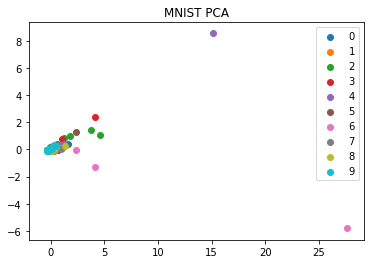

In [15]:
import scipy.linalg as LA
from sklearn.decomposition import PCA

def mnist_split_by_y(latents, ys):
    categories = []
    for i in range(10): 
        categories.append([])
    for i,y in enumerate(ys):
        categories[y].append(latents[i])
    return categories

def get_mean_latents(categories):
    mus = []
    for cat in categories:
        mus.append(np.mean(cat))
    return mus

def get_latents_variance(categories):
    vs = []
    for cat in categories:
        vs.append(np.var(cat))
    return vs

def pca(latents, ys):
    pca = PCA(n_components = 2)
    xpca = pca.fit(latents).transform(latents)
    xpcas = mnist_split_by_y(xpca, ys)
    print("Explained variance ratio: ", pca.explained_variance_ratio_)
    print(xpca.shape)
    print(len(xpcas))
    return xpcas

def plot_pca(xpcas):
    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for i, xp in enumerate(xpcas):
        xp = np.array(xp)
        #print(xp)
        #print(xp.shape)
        #print(i)
        #print(xp.shape)
        plt.scatter(xp[:,0], xp[:,1], label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('MNIST PCA')
    plt.show()

def latents_and_plot_pca(d, start, end):

    dat = d[start:end]
    ys = np.load("../mnist_ytrain.npy")[start:end]

    latents = m2.get_latents(dat)
    latents = np.array(latents)
    print(latents.shape)
    latents = latents/ 1e-6

    cats = mnist_split_by_y(latents, ys)
    print([len(cat) for cat in cats])
    mus =  get_mean_latents(cats)
    vs = get_latents_variance(cats)
    print(mus)
    print(vs)

    latents = np.array(latents)
    print(latents.shape)
    latents = np.reshape(latents, (end-start,50))
    
    # do pca
    xpcas = pca(latents, ys)
    # and plot
    plot_pca(xpcas)
    

latents_and_plot_pca(d,1050,1500)
